# Analyzing the Stavanger parking lots 

# The datasets

The datasets parkering2018.csv and parkering2017.csv contain data about the **hourly occupancy precentage** for 9 different parking lots in Stavanger. The data is open to the public, and can be found using the links below: 

- [Parking 2017](https://data.norge.no/nb/datasets/324aa45a-6797-4913-b0f7-642bf12e5b8f)
- [Parking 2018](https://data.norge.no/nb/datasets/0b3586a1-c740-4c60-ae4a-6be92845d5a6)


Both datasets have the same columns, and are structured the same way:
- `Dato` contains the date, format 'dd-mnt-17' or 'dd-mnt-18'
- `Tid` - contains the hour of the day, format 'dd:dd'
- `Siddis` - occupancy percentage for this parking lot
- `Forum` - occupancy percentage for this parking lot
- `Jernbanen` - occupancy percentage for this parking lot
- `Posten` - occupancy percentage for this parking lot
- `Jorenholmen` - occupancy percentage for this parking lot
- `St. Olav` - occupancy percentage for this parking lot
- `Valberget` - occupancy percentage for this parking lot
- `Kyrre` - occupancy percentage for this parking lot
- `Parketten` - occupancy percentage for this parking lot

## Challenges with the datasets

The first thing we notice, is that the date and time columns are not in what we would call a standard format. A quick test confirms the suspicion: it's not direclty possible to convert the date to a `datetime` object without preprocessing. We'll need to clean the formatting to enable this. 

The `Tid` column contains values such as `0:00`, `1:00`, ..,`22:00`, `23:00`, with one expection: **Feb 15th 2017** has an entry at `02:01` , but not `02:00`. If left as is, it will create issues when we later want to group the data on hour. Therefore we will replace the problematic value with 02:00. 

Other than that, the datasets are clean and well-structured. 

## Preliminaries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# collection of variables that will be useful later on:
parkinglots = ['Siddis', 'Forum', 'Jernbanen', 'Posten', 'Jorenholmen', 'St. Olav', 'Valberget', 'Kyrre', 'Parketten']

#list of labels:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = ['00','01','02','03','04','05','06','07','08','09', '10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hours_every_other = ['00','','02','','04','','06','','08','','10','','12','','14', '','16','','18','','20','','22', '']
hours_every_four = ['','01','','','','05','','','','09','','','','13','','','','17','','','','21','', '']


def fix_date(date):
    '''
    A helper function that reformats the Dates to a format that can then be converted to a datetime object
    '''
    day = str(date[0])
    month= str(date[1])
    year = '20' + str(date[2])
    
    if month == 'mai':
        month = 'may'
    elif month == 'okt':
        month = 'oct'
    elif month == 'des':
        month = 'dec'
    return year + '-' + month + '-' + day

## 2018: reading and cleaning

In [290]:
parkering2018 = pd.read_csv('parkering2018.csv')
parkering2018.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,1-jan-18,0:00,"3,0","0,0","19,0","11,0","17,0","22,0","12,0","14,0","13,0"
1,1-jan-18,1:00,"3,0","0,0","18,0","5,0","14,0","21,0","10,0","15,0","13,0"
2,1-jan-18,2:00,"2,0","0,0","17,0","6,0","15,0","21,0","6,0","15,0","4,0"
3,1-jan-18,3:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"
4,1-jan-18,4:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"


In [291]:
#Fixing the dates, and adding date+time as a datetime object in a seperate column
parkering2018['Dato'] = parkering2018['Dato'].str.split('-')
parkering2018['Time'] = parkering2018['Dato'].apply(fix_date) + ' ' + parkering2018['Tid'] #collecting date + time into a separate column
parkering2018['Time'] = pd.to_datetime(parkering2018['Time'], format='%Y-%b-%d %H:%M') #converting the new column to datetime

# Converting the numericals to ratios (floating numbers between 0 and 1)
for lot in parkinglots:
    parkering2018[lot] = parkering2018[lot].str.replace(',','.')
    parkering2018[lot] = parkering2018[lot].astype('float32')
    parkering2018[lot] = parkering2018[lot]/100

#adding a couple of extra columns for future ease. No new information here, just a better setup for visualisations below
parkering2018['Month'] = parkering2018['Time'].dt.month # jan=1, ..., dec=12
parkering2018['Hour'] = parkering2018['Tid'].str.split(':').str[0].astype('int32')

parkering2018 = parkering2018.drop(columns=["Dato", "Tid"])

#previewing the final dataframe:
parkering2018.head()

,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Time,Month,Hour
0,0.03,0.0,0.19,0.11,0.17,0.22,0.12,0.14,0.13,2018-01-01 00:00:00,1,0
1,0.03,0.0,0.18,0.05,0.14,0.21,0.10,0.15,0.13,2018-01-01 01:00:00,1,1
2,0.02,0.0,0.17,0.06,0.15,0.21,0.06,0.15,0.04,2018-01-01 02:00:00,1,2
3,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 03:00:00,1,3
4,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 04:00:00,1,4


## 2017: reading and cleaning

In [292]:
parkering2017 = pd.read_csv('parkering2017.csv')
parkering2017['Dato'] = parkering2017['Dato'].str.split('-')
# print(parkering2017.isna().sum())
parkering2017 = parkering2017.dropna() #one row with pure NaN
parkering2017.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,"[1, jan, 17]",0:00,"2,0","0,0","16,0","15,0","15,0","21,0","8,0","18,0","4,0"
1,"[1, jan, 17]",1:00,"2,0","0,0","11,0","6,0","12,0","19,0","7,0","17,0","4,0"
2,"[1, jan, 17]",2:00,"2,0","0,0","11,0","4,0","12,0","18,0","6,0","18,0","4,0"
3,"[1, jan, 17]",3:00,"2,0","0,0","11,0","3,0","12,0","18,0","6,0","17,0","4,0"
4,"[1, jan, 17]",4:00,"2,0","0,0","11,0","2,0","12,0","17,0","5,0","17,0","4,0"


In [293]:
# # Feb 15th have a registration at 02:01 instead of 02:00
parkering2017['Tid'] = parkering2017['Tid'].replace({
    '2:01': '2:00'
})

parkering2017['Tid'].unique() #validating the fix

array(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00',
       '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

In [294]:
parkering2017['Time'] = parkering2017['Dato'].apply(fix_date) + ' ' + parkering2017['Tid']
parkering2017['Time'] = pd.to_datetime(parkering2017['Time'], format='%Y-%b-%d %H:%M')

for lot in parkinglots:
    parkering2017[lot] = parkering2017[lot].str.replace(',','.')
    parkering2017[lot] = parkering2017[lot].astype('float32')
    parkering2017[lot] = parkering2017[lot]/100


parkering2017['Month'] = parkering2017['Time'].dt.month # jan=1, ..., dec=12
parkering2017['Hour'] = parkering2017['Tid'].str.split(':').str[0].astype('int32')

parkering2017 = parkering2017.drop(columns=["Dato", "Tid"])

#previewing final dataframe:
parkering2017.head()

,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Time,Month,Hour
0,0.02,0.0,0.16,0.15,0.15,0.21,0.08,0.18,0.04,2017-01-01 00:00:00,1,0
1,0.02,0.0,0.11,0.06,0.12,0.19,0.07,0.17,0.04,2017-01-01 01:00:00,1,1
2,0.02,0.0,0.11,0.04,0.12,0.18,0.06,0.18,0.04,2017-01-01 02:00:00,1,2
3,0.02,0.0,0.11,0.03,0.12,0.18,0.06,0.17,0.04,2017-01-01 03:00:00,1,3
4,0.02,0.0,0.11,0.02,0.12,0.17,0.05,0.17,0.04,2017-01-01 04:00:00,1,4


# Visualization

We will focus on the hourly average occupancy precentage, and aim to visualize this for each parking lot in different ways. We start of with a case study, focusing on a single parking lot, before exploring patterns within all, and between, all parking lots in the dataset. 

In [ ]:
# colors we will use: 
colors = ['C0', 'C8', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C9']
colors2 = ['C5', 'C7', 'C6', 'C9', 'C1', 'C0', 'C2', 'C8', 'C3']

angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler

#Hourly averages for each lot for each year
parkinglots_hourly_avg_2017 = [] # List of Series objects, one for each lot
parkinglots_hourly_avg_2018 = [] # List of Series objects, one for each lot

for lot in parkinglots: 
    parkinglots_hourly_avg_2017.append(parkering2017.groupby('Hour')[lot].mean().sort_index()) #sort index to make sure it is plotted in correct order starting at midnight
    parkinglots_hourly_avg_2018.append(parkering2018.groupby('Hour')[lot].mean().sort_index())


## Case study: Forum parking lot

We start off by a case study of the Forum parking lot. We did this for two reasons: 
- it's a good way to get to know the data, before starting to compare data between the parking lots
- it's a good way to play around with different visualizations before

Forum parking lot is not chosen for any particular reason. 

In [367]:
def bar_chart_single_lot(hourly_average_2017, hourly_average_2018, lotname, ax):
    '''
    Function for plotting the bar chart of hourly averages for 2017 and 2018 for single parking lot. 
    '''
    w, x = 0.3, np.arange(24)
    ax.bar(x-w/2, hourly_average_2017.values, label='2017', width=0.2, alpha=0.8, color='C0')
    ax.bar(x+w/2, hourly_average_2018.values, label='2018', width=0.2, alpha=0.8, color='C8')

    ax.set_xlabel('Hour')
    ax.set_ylabel('Occupancy ratio')
    ax.set_title(f"Hourly average occupancy at {lotname}")
    ax.legend()

The bar chart is a fairly standard way to represent this kind of data, and is a good way to spot obvious patterns. In this case, we see that the parkin lot occupancy follows roughly the same pattern in 2017 and 2018, but that the occupancy during evening hours seems to have gone down in 2018 compared to 2017. 

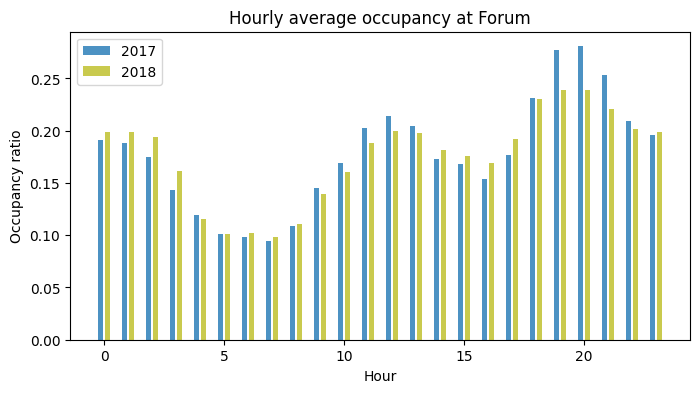

In [359]:
fig, ax = plt.subplots(figsize=(8,4), sharey=True)
bar_chart_single_lot(parkinglots_hourly_avg_2017[1], parkinglots_hourly_avg_2018[1], "Forum", ax)
plt.show()

Let's visualise the exact same data in two alternative ways: with polar coordinates and in a 3D stem plot: 

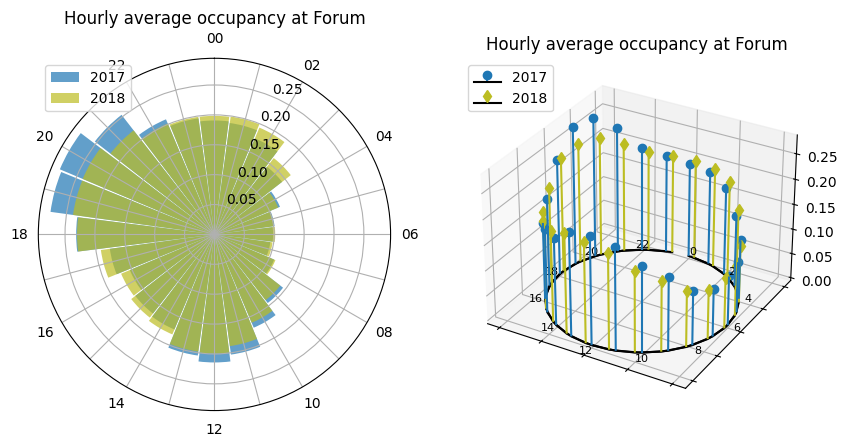

In [376]:
fig = plt.figure(figsize=(10, 7)) 

#### Plot 1: polar coordinates
ax0 = fig.add_subplot(1,2,1,projection='polar')

bars = ax0.bar(angles, parkinglots_hourly_avg_2017[1].values, width=0.25, alpha=0.7, label='2017') 
bars = ax0.bar(angles, parkinglots_hourly_avg_2018[1].values, width=0.25, color=colors[1], alpha=0.7, label ='2018') 

ax0.legend(loc='upper left') 
ax0.set_theta_zero_location("N")  # 12 o'clock starts at top
ax0.set_theta_direction(-1)       # Clockwise
ax0.set_xticks(angles)
ax0.set_xticklabels(hours_every_other)
ax0.set_title("Hourly average occupancy at Forum")

#### Plot 2: 3D stem

ax1 = fig.add_subplot(1,2,2,projection='3d')

x1 = np.sin(np.linspace(0, 2 * np.pi, 24, endpoint=False)) 
y1 = np.cos(np.linspace(0, 2 * np.pi, 24, endpoint=False)) 
z1 = parkinglots_hourly_avg_2017[1].values

d = 0.07 #want the 2018 stems to be close to 2017, but not at the same exact spot
x2 = np.sin(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) 
y2 = np.cos(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) 
z2 = parkinglots_hourly_avg_2018[1].values

ax1.stem(x1,y1,z1, 
        basefmt = 'k-',
        label='2017')

ax1.stem(x2,y2,z2, 
        linefmt = f'{colors[1]}-', #vertical line
        markerfmt=f'{colors[1]}d', #stem head
        basefmt='k-', #baseline
        label='2018')

ax1.legend(loc='upper left')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title("Hourly average occupancy at Forum")

for i, (xi, yi) in enumerate(zip(x1, y1)):
    if i%2==0:
            ax1.text(xi * 1.1, yi * 1.1, 0, str(i), ha='center', va='center', fontsize=8)

plt.show()

## Hourly averages 2018

We now move on to explore the other parking lots as well, using the same techniques and plot types as we did in the case study. 

We again start of with a bar chart across the hourly average occupancies, for all parking lots. We have limited this plot to 2018, not to make it more messy than necessary. The use patterns are roughly the same for all parking lots in 2017 too. 

One initial observation is that there seem to be different use patterns of the different parking lots. Some have much more variation in occupancy throught the day, typically being used a lot less during evenings and nights. Other parking lots, have less variation, and a more steady use across the different hours of the day. 

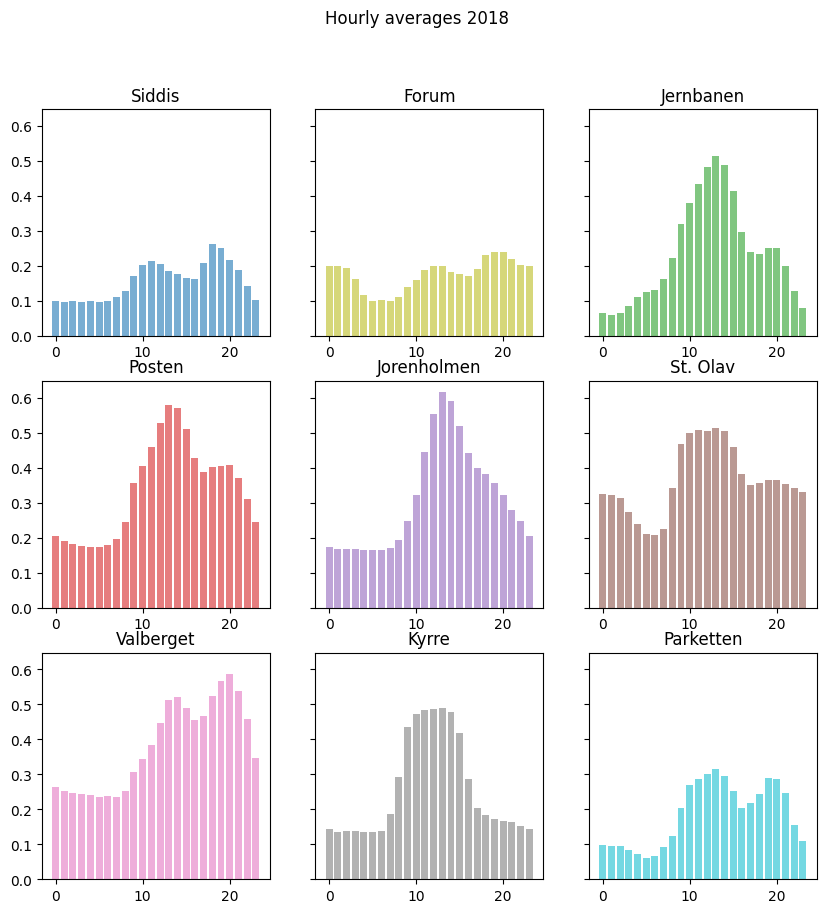

In [374]:
fig, ax = plt.subplots(3,3,figsize=(10,10), sharey=True)

n_bins = 24
i = 0
j = 0
for k in range(9):
    ax[i,j].bar(parkinglots_hourly_avg_2018[k].index, parkinglots_hourly_avg_2018[k].values, color=colors[k], alpha=0.6, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden    
    ax[i,j].set_title(parkinglots[k])

    j += 1
    if j == 3:
        i += 1
        j = 0

plt.suptitle("Hourly averages 2018")
plt.show()

## Hourly averages 2017 vs 2018 (polar)

As we did in the case study, we will now plot the same data in alternative ways. 

First we plot the data for 2018. Note that in this visual we have used the same r-axis across subplots. This enables us not only to see the variation of occupancy on one parking lot, but also between the parking lots. 

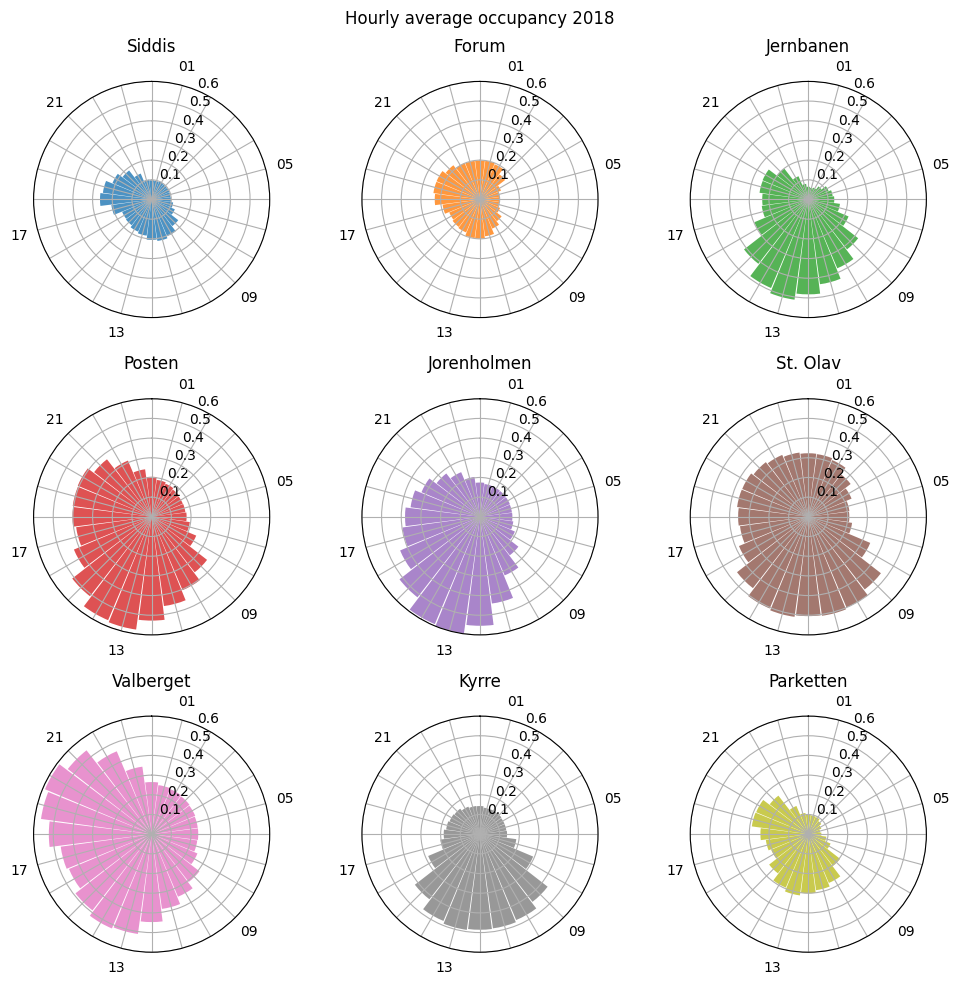

In [298]:
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler

fig, ax = plt.subplots(3,3,figsize=(10,10), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors[k], alpha=0.8, label=parkinglots[k]) #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k], fontsize=12)
    
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    # ax[i,j].set_yticklabels([])

    ax[i,j].set_rlim(0,0.6) #fixing the r-axis so all subplots have the same

    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.suptitle("Hourly average occupancy 2018")
plt.tight_layout()
plt.show()

We want to use the same method to compare the hourly average occupancy between 2017 and 2018. Below is the same visualization as above, but for each parking lot we have plotted the data from 2017 and 2018 with different colors.  

**Note:** In this plot we have *not* fixed r axis because we want to compare each lot with itself over the two years, not make any comparisons between the lots.

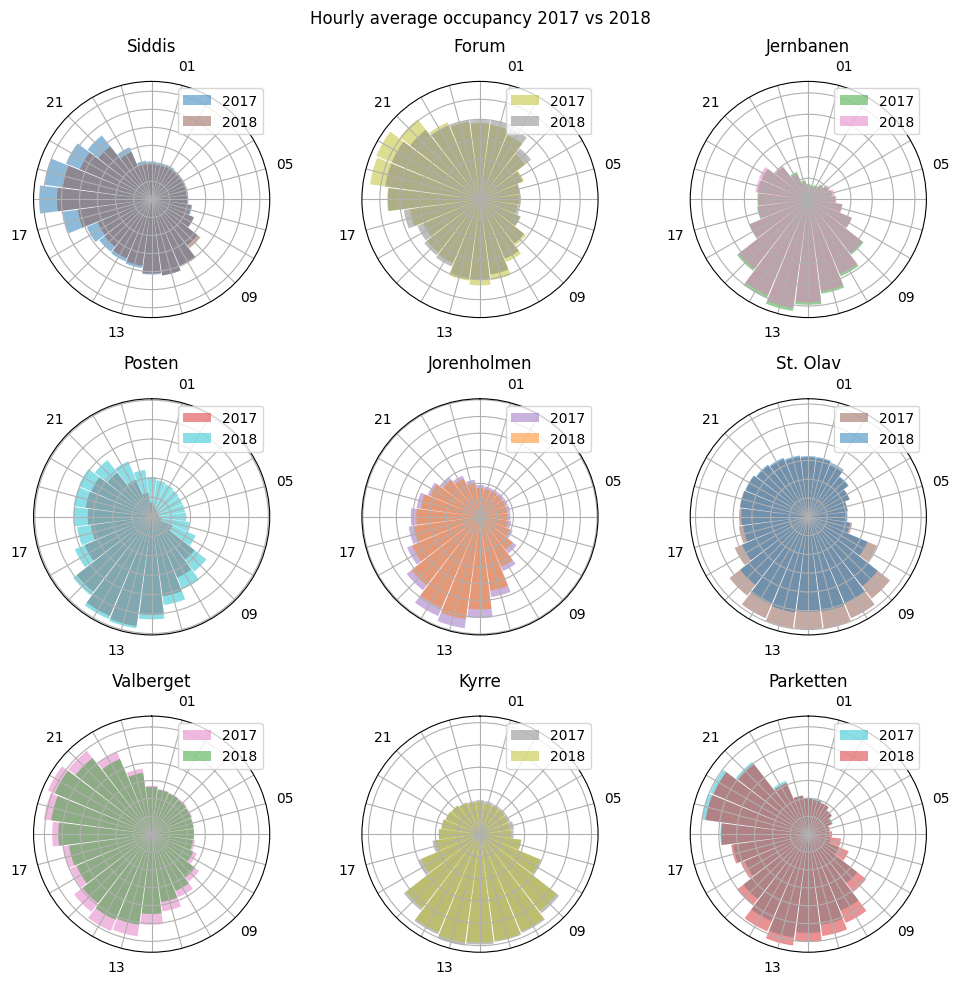

In [321]:
fig, ax = plt.subplots(3,3,figsize=(10,10), subplot_kw={'projection': 'polar'}, squeeze=False)

i = 0
j = 0
for k in range(9):
    ax[i,j].bar(angles, parkinglots_hourly_avg_2017[k].values, width=0.25, color=colors[k], alpha=0.5, label='2017') #alpha styrer gjennomsiktighetsgraden
    ax[i,j].bar(angles, parkinglots_hourly_avg_2018[k].values, width=0.25, color=colors2[k], alpha=0.5, label='2018') #alpha styrer gjennomsiktighetsgraden
    ax[i,j].set_title(parkinglots[k])
    ax[i,j].legend(loc='best') 
    ax[i,j].set_xticks(angles)
    ax[i,j].set_xticklabels(hours_every_four)
    ax[i,j].set_yticklabels([])
    ax[i,j].set_theta_direction(-1)       # Clockwise
    ax[i,j].set_theta_zero_location("N")  # 12 o'clock starts at top

    j += 1

    if j == 3:
        i += 1
        j = 0

plt.suptitle("Hourly average occupancy 2017 vs 2018")
plt.tight_layout()
plt.show()

## Hourly occupancy: 3D stem plots

We now want to visualize the hourly average occupancy on each parking lot for 2017 and 2018 using 3D stemp plots. We see that the stem plots usability will vary with each individual parking lots use pattern. The plots more challenging to read when the use pattern is in a way such that the stems in the front is taller than the ones in the back (for example `Kyrre` or `Parketten`). 

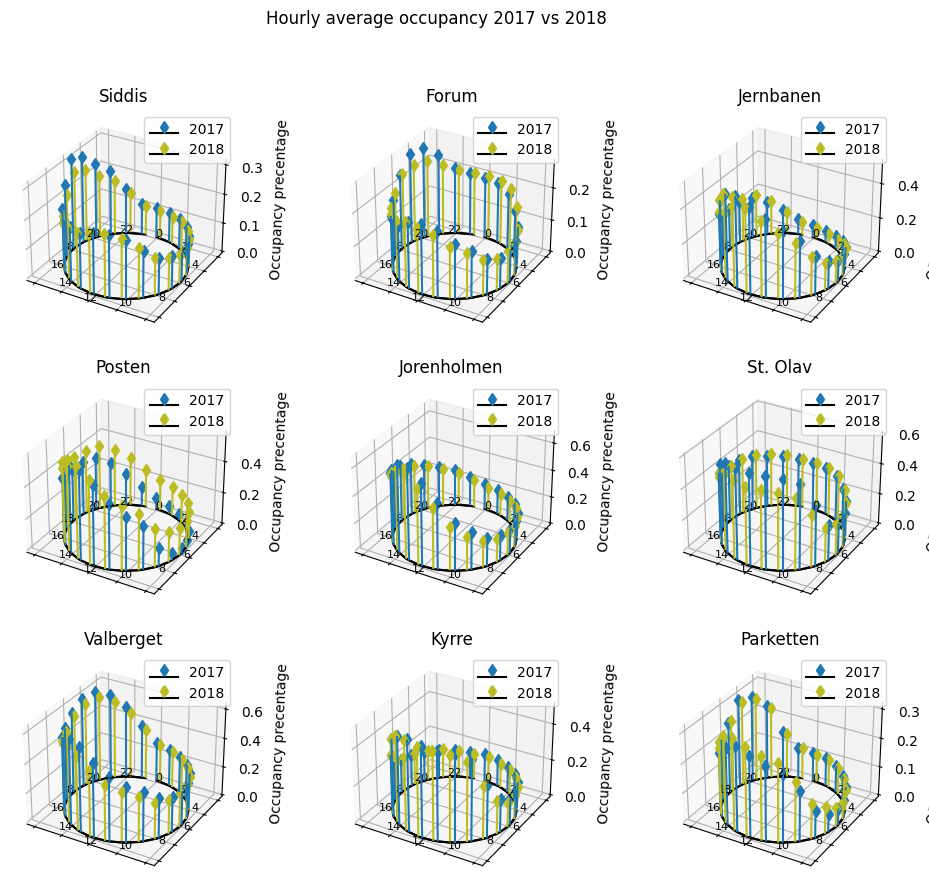

In [383]:
fig, ax = plt.subplots(3,3,figsize=(12,10), subplot_kw={'projection': '3d'}, squeeze=False)

x1 = np.sin(np.linspace(0, 2 * np.pi, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
y1 = np.cos(np.linspace(0, 2 * np.pi, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler

d = 0.07 #want the 2018 stems to be close to 2017, but not at the same exact spot
x2 = np.sin(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler
y2 = np.cos(np.linspace(0 + d, 2 * np.pi + d, 24, endpoint=False)) #deler opp sirkel (2*pi) i 24 like store deler

i = 0
j = 0
for k in range(9):
   z1 = parkinglots_hourly_avg_2017[k].values
   z2 = parkinglots_hourly_avg_2018[k].values
   
   ax[i,j].stem(x1,y1,z1,
     linefmt = f'{colors[0]}-', #vertical line
     markerfmt=f'{colors[0]}d', #stem head
     basefmt = 'k-',
     label='2017')
#    color = 'C5'
   
   ax[i,j].stem(x2,y2,z2, 
     linefmt = f'C8-', #vertical line
     markerfmt=f'C8d', #stem head
     basefmt='k-', #baseline
     label='2018')
   
   ax[i,j].set_xticklabels([])
   ax[i,j].set_yticklabels([])
   ax[i,j].set_zlabel("Occupancy precentage")
   ax[i,j].set_title(parkinglots[k])
   ax[i,j].legend()
   
   for n, (xn, yn) in enumerate(zip(x1, y1)):
     if n%2==0:
          ax[i,j].text(xn * 1.1, yn * 1.1, 0, str(n), ha='center', va='center', fontsize=8)
   
   j += 1
   if j == 3:
     i += 1
     j = 0

plt.suptitle("Hourly average occupancy 2017 vs 2018")
plt.show()

## Just for fun :) 

We end the report with a visualisation that we made just for fun. It contains the data for 2018 for all parkinglots, in one single plot. 

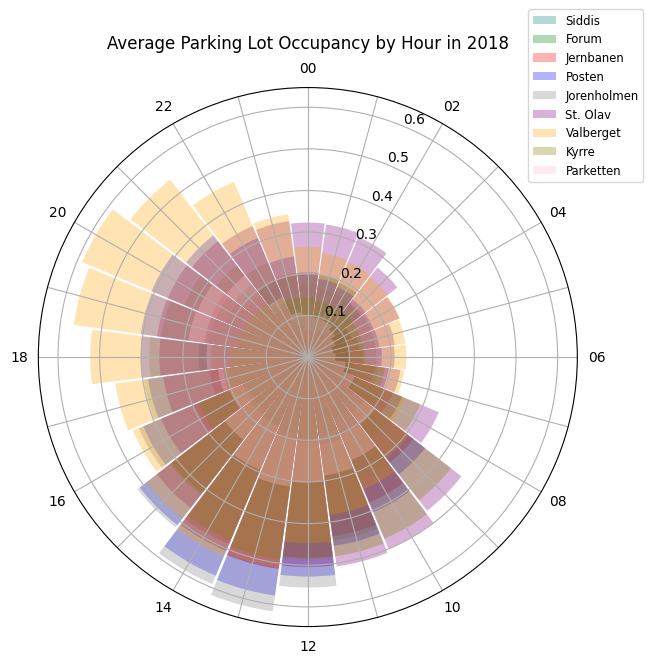

In [268]:
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': 'polar'})

i=0
for lot_avg in parkinglots_hourly_avg_2018:
    bars = ax.bar(angles, parkinglots_hourly_avg_2018[i].values, width=0.25, color=colors[i], alpha=0.3, label=parkinglots[i]) #alpha styrer gjennomsiktighetsgraden
    i += 1

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,1), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser
ax.set_title("Average Parking Lot Occupancy by Hour in 2018", va='bottom')
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)

ax.set_theta_direction(-1)       # Clockwise
ax.set_theta_zero_location("N")  # 12 o'clock starts at top

plt.show()

# Conclusions

As mentioned in the README, I have very limited knowledge of Stavanger, its neighborhoods, and the locations of these parking lots. The only lot I can reasonably guess the location of is Jernbanen, which I assume is near the central train station and therefore close to the city center.

Based on the visualizations, I’ve formed the following hypotheses:

St. Olav, Forum, Siddis, Posten, and Valberget all maintain occupancy levels above 10% throughout the entire day. This suggests that they may serve areas where overnight parking is common—such as near:

- Hospitals
- Hotels or conference centers
- Airports

Kyrre shows high occupancy only during a narrow window between 10 AM and 3 PM. This could indicate that it's located near a school, university, or large workplace.

More generally, the 3D stem plot proved to be a creative and visually engaging way to present the data. However, its effectiveness depends on the nature of the dataset and the chosen orientation. Careful adjustment of the plot's viewpoint is often needed to make the most of this type of visualization.